<a href="https://colab.research.google.com/github/ark1st/2020_AI/blob/master/bert_ner_i2b2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from google.colab import drive 

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!pip install transformers
import transformers

     |████████████████████████████████| 1.8MB 11.1MB/s 
     |████████████████████████████████| 890kB 38.4MB/s 
     |████████████████████████████████| 2.9MB 42.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0d99dcc0d0adab71ba924e045fc071e4c60df369611aaa2e689ce54854c2c9b7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
from tqdm import tqdm, trange

In [6]:
import pickle
"""
def sep_corpora(corpora):
    words, tags = [[] for i in range(len(corpora))], [[] for i in range(len(corpora))]
    for i, corpus in enumerate(corpora):
        for wordNtags in corpus:
            temp = wordNtags.split(" ")
            words[i].append(temp[0])
            tags[i].append(temp[1].replace("\n", ""))
    return words, tags

with open("/content/gdrive/MyDrive/Colab Notebooks/De-ID/i2b2 2014/train_corpora","rb") as fr:
    train_corpora = pickle.load(fr)

with open("/content/gdrive/MyDrive/Colab Notebooks/De-ID/i2b2 2014/test_corpora","rb") as fr:
    test_corpora = pickle.load(fr)

train_words, train_tags = sep_corpora(train_corpora)
test_words, test_tags = sep_corpora(test_corpora)

"""



'\ndef sep_corpora(corpora):\n    words, tags = [[] for i in range(len(corpora))], [[] for i in range(len(corpora))]\n    for i, corpus in enumerate(corpora):\n        for wordNtags in corpus:\n            temp = wordNtags.split(" ")\n            words[i].append(temp[0])\n            tags[i].append(temp[1].replace("\n", ""))\n    return words, tags\n\nwith open("/content/gdrive/MyDrive/Colab Notebooks/De-ID/i2b2 2014/train_corpora","rb") as fr:\n    train_corpora = pickle.load(fr)\n\nwith open("/content/gdrive/MyDrive/Colab Notebooks/De-ID/i2b2 2014/test_corpora","rb") as fr:\n    test_corpora = pickle.load(fr)\n\ntrain_words, train_tags = sep_corpora(train_corpora)\ntest_words, test_tags = sep_corpora(test_corpora)\n\n'

In [7]:
"""
def splitList(array):
       n = len(array)
       half = int(n/2) # py3
       return array[:half], array[n-half:]

def split(arrlist):
  NEW = []
  for arr in arrlist:
    a, b = splitList(arr)
    NEW.append(a)
    # NEW.append(b)
  return NEW
  """

'\ndef splitList(array):\n       n = len(array)\n       half = int(n/2) # py3\n       return array[:half], array[n-half:]\n\ndef split(arrlist):\n  NEW = []\n  for arr in arrlist:\n    a, b = splitList(arr)\n    NEW.append(a)\n    # NEW.append(b)\n  return NEW\n  '

In [8]:
import ast
train_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/De-ID/i2b2 2014/sep_df_Train.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/De-ID/i2b2 2014/sep_df_Test.csv')

train_df['words'] = train_df['words'].apply(ast.literal_eval) 
train_df['tags'] = train_df['tags'].apply(ast.literal_eval) 
test_df['words'] = test_df['words'].apply(ast.literal_eval) 
test_df['tags'] = test_df['tags'].apply(ast.literal_eval) 

train_df.head()

,index,num,words,tags
0,0,0,"[Record, date:, 2083-10-18, CARDIOLOGY, WETZEL...","[O, O, B-DATE, O, B-HOSPITAL, I-HOSPITAL, I-HO..."
1,0,1,"[25, years., He, is, not, married,, no, childr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,0,2,"[tracing, is, Unchanged, Selected, recent, lab...","[O, O, O, O, O, O, O, B-DATE, O, O, O, O, O, O..."
3,1,0,"[Record, date:, 2081-04-13, CARDIOLOGY, ALGIER...","[O, O, B-DATE, O, B-HOSPITAL, I-HOSPITAL, I-HO..."
4,1,1,"[history:, Unchanged, from, previous, visits.,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-CITY..."


In [9]:
New_train_words , New_train_tags =  train_df['words'], train_df['tags']
New_test_words , New_test_tags =  test_df['words'], test_df['tags']



In [10]:
"""
with open("/content/gdrive/MyDrive/Colab Notebooks/De-ID/Aug/augmented.pickle","rb") as fr:
    aug_corpora = pickle.load(fr)

aug_words=[]
aug_tags = []

for aug in aug_corpora:
  word_temp=[]
  tag_temp=[]
  for cop in aug:
    word_temp.append(cop[0])
    tag_temp.append(cop[1])
  aug_words.append(word_temp)
  aug_tags.append(tag_temp)

len(aug_words), len(aug_tags)

aug_words = aug_words[:1000]
aug_tags = aug_tags[:1000]
"""

'\nwith open("/content/gdrive/MyDrive/Colab Notebooks/De-ID/Aug/augmented.pickle","rb") as fr:\n    aug_corpora = pickle.load(fr)\n\naug_words=[]\naug_tags = []\n\nfor aug in aug_corpora:\n  word_temp=[]\n  tag_temp=[]\n  for cop in aug:\n    word_temp.append(cop[0])\n    tag_temp.append(cop[1])\n  aug_words.append(word_temp)\n  aug_tags.append(tag_temp)\n\nlen(aug_words), len(aug_tags)\n\naug_words = aug_words[:1000]\naug_tags = aug_tags[:1000]\n'

In [11]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [12]:
train_sentences = New_train_words
test_sentences = New_test_words
train_labels =  New_train_tags
test_labels = New_test_tags

In [13]:
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/De-ID/i2b2 2014/dataframe.csv')
data

,Unnamed: 0,Word,Tag
0,0,Record,O
1,1,date:,O
2,2,2083-10-18,B-DATE
3,3,CARDIOLOGY,O
4,4,WETZEL,B-HOSPITAL
...,...,...,...
815121,815121,Frank,B-DOCTOR
815122,815122,T.,I-DOCTOR
815123,815123,Xuan,I-DOCTOR
815124,815124,",",O


In [14]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [15]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.7.0+cu101'

In [16]:
MAX_LEN = 256
bs = 32

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [18]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [19]:
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', do_lower_case=False)

In [20]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [21]:
train_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(train_sentences, train_labels)
]

test_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(test_sentences, test_labels)
]

In [22]:
train_tokenized_texts = [token_label_pair[0] for token_label_pair in train_tokenized_texts_and_labels]
train_labels = [token_label_pair[1] for token_label_pair in train_tokenized_texts_and_labels]

test_tokenize_texts = [token_label_pair[0] for token_label_pair in test_tokenized_texts_and_labels]
test_labels = [token_label_pair[1] for token_label_pair in test_tokenized_texts_and_labels]

In [23]:
test_tokenize_texts[0][:10], test_labels[0][:10]

(['Record', 'date', ':', '206', '##8', '-', '03', '-', '31', 'E'],
 ['O',
  'O',
  'O',
  'B-DATE',
  'B-DATE',
  'B-DATE',
  'B-DATE',
  'B-DATE',
  'B-DATE',
  'B-HOSPITAL'])

In [24]:
train_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in train_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenize_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [25]:
train_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in train_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

test_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in test_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [26]:
train_attention_masks = [[float(i != 0.0) for i in ii] for ii in train_input_ids]
test_attention_masks = [[float(i != 0.0) for i in ii] for ii in test_input_ids]

In [27]:
# tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
#                                                             random_state=2018, test_size=0.4)

# tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
#                                              random_state=2018, test_size=0.4)

tr_inputs, val_inputs, tr_tags, val_tags = train_input_ids, test_input_ids, train_tags, test_tags

tr_masks, val_masks = train_attention_masks, test_attention_masks


In [28]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [29]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [30]:
len(train_data)

2379

In [31]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'4.2.1'

In [32]:
model = BertForTokenClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint 

In [33]:
model.cuda();


In [34]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [35]:
from transformers import get_linear_schedule_with_warmup

epochs = 5
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [36]:
!pip install seqeval==0.0.17
from seqeval.metrics import f1_score, accuracy_score


  Created wheel for seqeval: filename=seqeval-0.0.17-cp36-none-any.whl size=7640 sha256=a807a29b157895275116569df820549e4a9368fb59508b6c180c0bb304c6c18e
  Stored in directory: /root/.cache/pip/wheels/6a/c8/cf/7b9d5d52984c08ce4d27d6f858a682ef74a3738f43f489166a
Successfully built seqeval


In [37]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Average train loss: 0.46635768791039783
Validation loss: 0.15203279039512077
Validation Accuracy: 0.9623324691059554


Epoch:  20%|██        | 1/5 [04:51<19:26, 291.66s/it]

Validation F1-Score: 0.6407932573128409

Average train loss: 0.1169575297832489
Validation loss: 0.08729325281456113
Validation Accuracy: 0.9766880917248144


Epoch:  40%|████      | 2/5 [09:43<14:35, 291.84s/it]

Validation F1-Score: 0.7701284002653865

Average train loss: 0.06963698461651802
Validation loss: 0.06270844590229292
Validation Accuracy: 0.9839437112869207


Epoch:  60%|██████    | 3/5 [14:36<09:43, 291.92s/it]

Validation F1-Score: 0.8351015517807797

Average train loss: 0.04995074848333995
Validation loss: 0.05455172422807664
Validation Accuracy: 0.9869365501488083


Epoch:  80%|████████  | 4/5 [19:28<04:51, 291.99s/it]

Validation F1-Score: 0.867928984765579

Average train loss: 0.041051155254244805
Validation loss: 0.052208208168546356
Validation Accuracy: 0.9879897404261113


Epoch: 100%|██████████| 5/5 [24:20<00:00, 292.06s/it]

Validation F1-Score: 0.8782435129740519



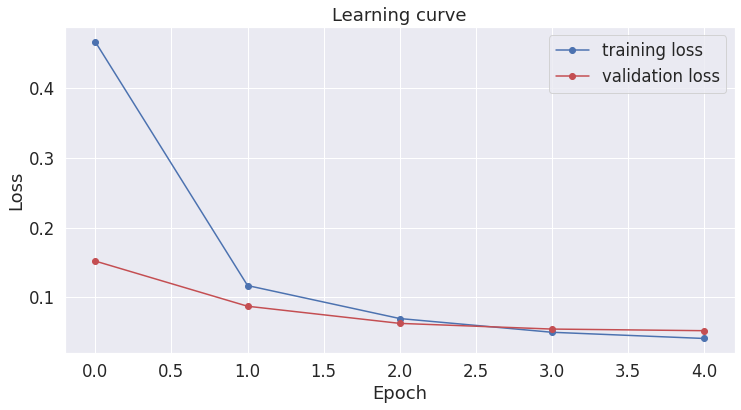

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [39]:
model.eval()
# Reset the validation loss for this epoch.
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []
for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients,
    # saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

eval_loss = eval_loss / len(valid_dataloader)
validation_loss_values.append(eval_loss)
print("Validation loss: {}".format(eval_loss))
pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                              for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
valid_tags = [tag_values[l_i] for l in true_labels
                              for l_i in l if tag_values[l_i] != "PAD"]
print("Validation Accuracy: {}".format(accuracy_score(valid_tags,pred_tags)))
print("Validation F1-Score: {}".format(f1_score(valid_tags,pred_tags)))
print()

Validation loss: 0.052208208168546356
Validation Accuracy: 0.9879897404261113
Validation F1-Score: 0.8782435129740519



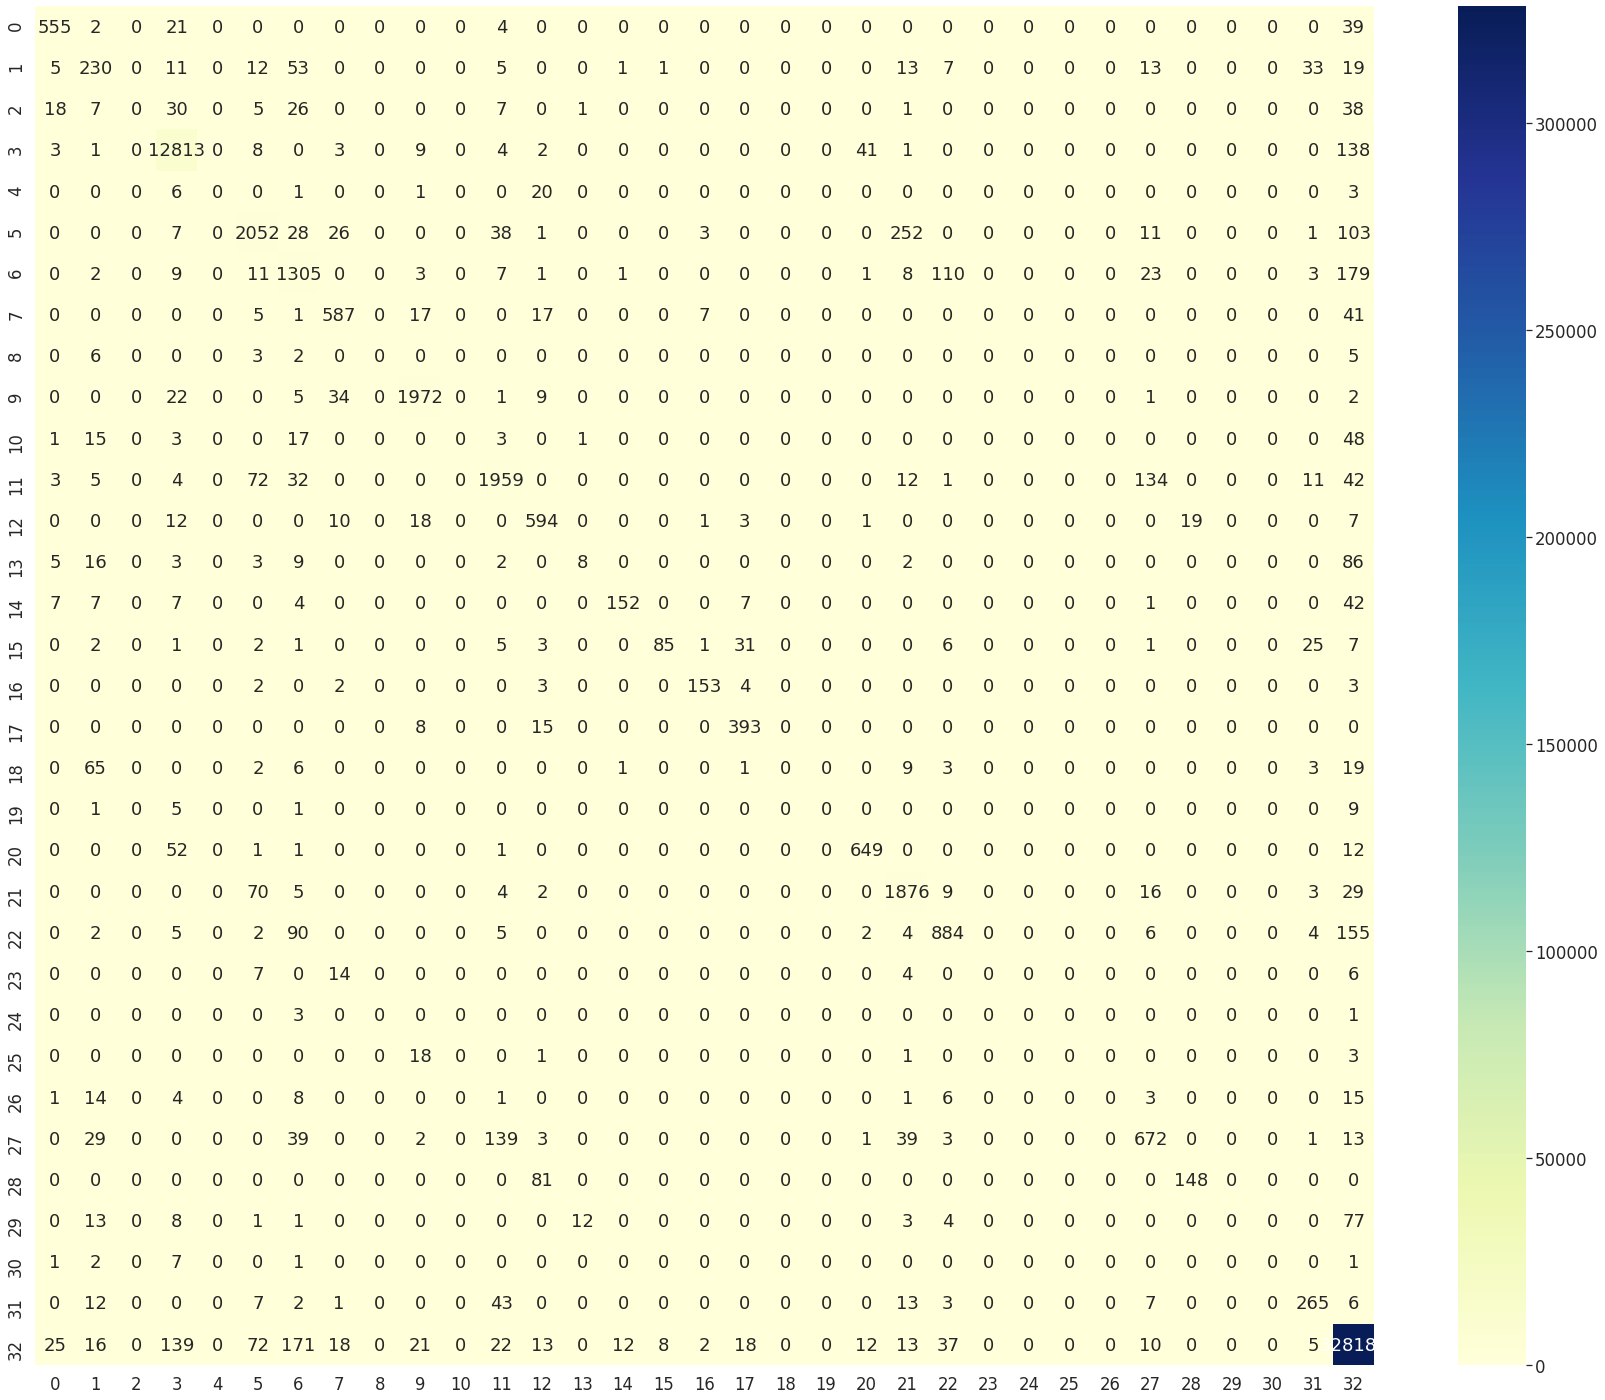

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(valid_tags, pred_tags)
plt.figure(figsize=(30,25))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")

In [45]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

print("Validation Accuracy: {}".format(accuracy_score(valid_tags,pred_tags)))
print("precision_score: {}".format(precision_score(valid_tags,pred_tags)))
print("recall_score: {}".format(recall_score(valid_tags,pred_tags)))
print("Validation F1-Score: {}".format(f1_score(valid_tags,pred_tags)))

Validation Accuracy: 0.9879897404261113
precision_score: 0.8777404700770294
recall_score: 0.8787471328007593
Validation F1-Score: 0.8782435129740519


In [46]:
print(classification_report(valid_tags,pred_tags))

                precision    recall  f1-score   support

           AGE       0.89      0.89      0.89       621
          CITY       0.44      0.49      0.47       404
       COUNTRY       0.00      0.00      0.00       133
          DATE       0.97      0.98      0.97     13024
        DEVICE       0.00      0.00      0.00        31
        DOCTOR       0.78      0.74      0.76      2525
      HOSPITAL       0.63      0.70      0.66      1665
         IDNUM       0.83      0.86      0.85       675
LOCATION-OTHER       0.00      0.00      0.00        16
 MEDICALRECORD       0.95      0.96      0.96      2046
  ORGANIZATION       0.00      0.00      0.00        88
       PATIENT       0.78      0.79      0.78      2275
         PHONE       0.74      0.85      0.79       665
    PROFESSION       0.00      0.00      0.00       135
         STATE       0.91      0.67      0.77       227
        STREET       0.43      0.40      0.41       173
      USERNAME       0.92      0.92      0.92  

In [43]:
c

NameError: ignored